In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

### DATA LOADING


In [2]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Movies_dataset.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data= spark.read.csv(dataset_path, header=True, inferSchema=True)
data.show()
data.printSchema()

+--------------------+-------------+------------+--------------------+--------+---------------+-----------------+-------+
|          Movie_Name|Certification|Release_Date|              Genres|Language|         Budget|          Revenue|Runtime|
+--------------------+-------------+------------+--------------------+--------+---------------+-----------------+-------+
|Black Panther: Wa...|         PG13|  11/10/2022|['Action,', 'Adve...| English|$250,000,000.00|  $835,000,000.00|  162.0|
|Puss in Boots: Th...|           PG|  12/08/2022|['Animation,', 'A...| English| $90,000,000.00|  $369,105,725.00|  103.0|
|     Shotgun Wedding|            R|  12/28/2022|['Action,', 'Roma...| English|              -|    $4,495,365.00|  101.0|
|               M3GAN|         PG13|  01/05/2023|['Science Fiction...| English| $12,000,000.00|  $158,000,000.00|  102.0|
|         Transfusion|        MA15+|  01/05/2023|['Crime,', 'Thril...| English|              -|                -|  105.0|
|Detective Knight:...|  

In [4]:
from pyspark.sql.functions import regexp_replace, col ,to_date,split,trim

# Converting Budget and Revenue to Integer
data = data.withColumn("Budget", regexp_replace(col("Budget"), "[\$,]", ""))
data = data.withColumn("Revenue", regexp_replace(col("Revenue"), "[\$,]", ""))

# Converingt string columns to integer
data = data.withColumn("Budget", col("Budget").cast("integer"))
data = data.withColumn("Revenue", col("Revenue").cast("integer"))

# converting release_date into date time
data = data.withColumn("Release_Date", to_date("Release_Date", "dd/mm/yyyy"))

data = data.withColumn("Genres", regexp_replace(col("Genres"), "[\[\]']", "")) \
           .withColumn("Genres", regexp_replace(col("Genres"), "\s*,\s*", ",")) \
           .withColumn("Genres", split(col("Genres"), ","))

#Convert Runtime to Minutes
data = data.withColumn("Runtime", col("Runtime").cast("float").cast("int"))
# updated DataFrame
data.show(truncate =False)
data.printSchema()

+---------------------------------+-------------+------------+-------------------------------------------------------+--------+---------+---------+-------+
|Movie_Name                       |Certification|Release_Date|Genres                                                 |Language|Budget   |Revenue  |Runtime|
+---------------------------------+-------------+------------+-------------------------------------------------------+--------+---------+---------+-------+
|Black Panther: Wakanda Forever   |PG13         |2022-01-11  |[Action, , Adventure, , Science Fiction]               |English |250000000|835000000|162    |
|Puss in Boots: The Last Wish     |PG           |2022-01-12  |[Animation, , Adventure, , Comedy, , Family, , Fantasy]|English |90000000 |369105725|103    |
|Shotgun Wedding                  |R            |2022-01-12  |[Action, , Romance, , Comedy]                          |English |null     |4495365  |101    |
|M3GAN                            |PG13         |2023-01-01  |[S

In [7]:
from pyspark.sql.functions import explode, year, month
from pyspark.sql.functions import *
data_exploded = data.select(explode("Genres").alias("Genre"), "Revenue","Release_Date").filter(col("Genre")!="")

revenue_by_genre = data_exploded.groupBy("Genre",year("Release_Date").alias("Year")).agg(sum("Revenue").alias("Total_Revenue_by_Genre")).orderBy(col("Total_Revenue_by_Genre").desc())
#revenue_by_genre.groupBy('Genre').agg(first('Year').alias('Year'),first('Total_Revenue_by_Genre').alias('Total_Revenue_by_Genre')).orderBy(desc('Total_Revenue_by_Genre')).show()

top_10_genres = revenue_by_genre.groupBy("Genre") \
                                     .agg(sum("Total_Revenue_by_Genre").alias("Total_Revenue")) \
                                     .orderBy(desc("Total_Revenue")) \
                                     .limit(5) \
                                     .select("Genre");

  # Collect top 10 genres into a list
top_10_genres_list = [row.Genre for row in top_10_genres.collect()]


# Filter year-wise data for top 10 genres
top_10_genres_data = revenue_by_genre.filter(col("Genre").isin(top_10_genres_list))

top_10_genres_data = top_10_genres_data .filter(col("Year")>2015);

top_10_genres_data.select(top_10_genres_data.Genre).distinct().show()

top_10_genres_data.show()

+---------------+
|          Genre|
+---------------+
|      Adventure|
|        Fantasy|
|Science Fiction|
|         Comedy|
|         Action|
+---------------+

+---------------+----+----------------------+
|          Genre|Year|Total_Revenue_by_Genre|
+---------------+----+----------------------+
|         Action|2018|           17616115798|
|         Action|2017|           16670467411|
|      Adventure|2016|           15810937482|
|      Adventure|2018|           14999173485|
|      Adventure|2017|           14001870517|
|      Adventure|2019|           13526660242|
|         Action|2016|           12633342213|
|Science Fiction|2018|           10461873231|
|         Action|2022|           10013951196|
|      Adventure|2021|            9539854770|
|Science Fiction|2017|            8834850329|
|         Action|2019|            8653103717|
|        Fantasy|2017|            8628321761|
|         Comedy|2016|            8170939740|
|         Action|2021|            8115005697|
|        

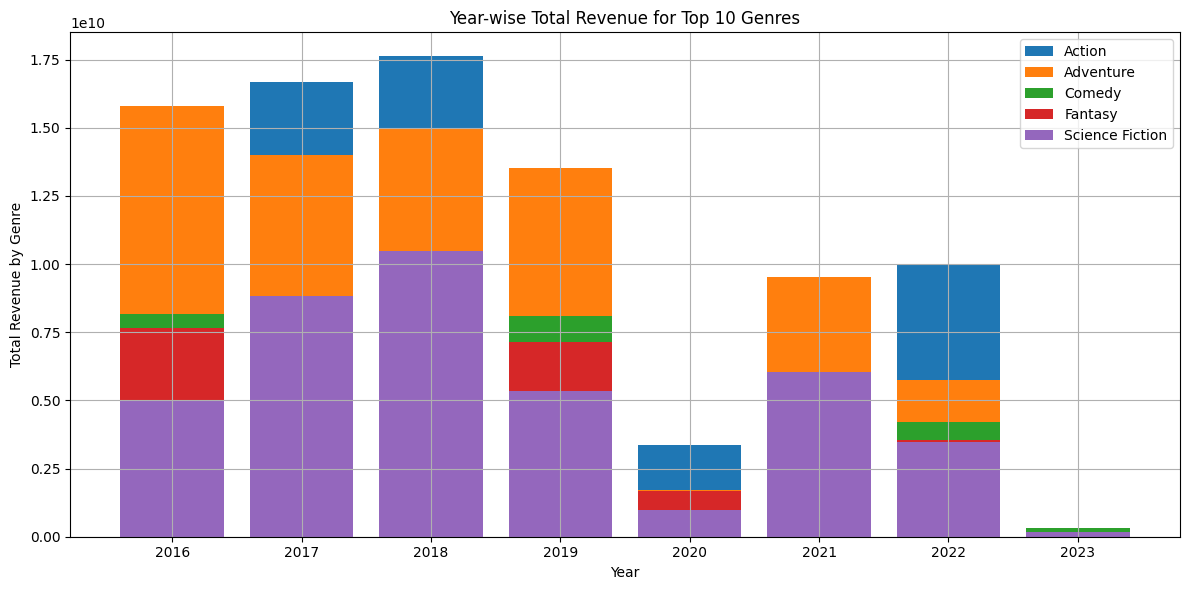

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert DataFrame to Pandas
top_10_genres_data_pd = top_10_genres_data.toPandas()

# Plot the data for each genre
plt.figure(figsize=(12, 6))
for genre, group in top_10_genres_data_pd.groupby("Genre"):
    plt.bar(group["Year"], group["Total_Revenue_by_Genre"], label=genre)
plt.xlabel("Year")
plt.ylabel("Total Revenue by Genre")
plt.title("Year-wise Total Revenue for Top 10 Genres")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
